# SVM with Smote Model for Twitter Sentiment Analysis

This model will use SVM with tf/idf to classify the tweets.

It will reduce the dimensionality of the feature set by adjusting the minimum document frequency of words, in an attempt to get better results.

It will use SMOTE to synthesize some data to balance the classes.

# Imports and Constants

In [1]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, plot_confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelBinarizer
import evaluation_functions
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
DATA_FILE_PATH = 'data/crowdflower-brands-and-product-emotions/data/'
TOKENIZED_DATA_FILE_NAME = 'tokenized_twitter_data.csv'
pd.set_option('display.max_colwidth', None)
RANDOM_STATE = 42

# Load Data

In [3]:
df = pd.read_csv(DATA_FILE_PATH + TOKENIZED_DATA_FILE_NAME)

In [4]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,tokens
0,i have a g iphone after hrs tweeting at #riseaustin it was dead i need to upgrade plugin stations at #sxsw,iPhone,Negative emotion,"['i', 'have', 'a', 'g', 'iphone', 'after', 'hrs', 'tweeting', 'at', '#riseaustin', 'it', 'was', 'dead', 'i', 'need', 'to', 'upgrade', 'plugin', 'stations', 'at', '#sxsw']"
1,know about awesome ipad/iphone app that you'll likely appreciate for its design also they're giving free ts at #sxsw,iPad or iPhone App,Positive emotion,"['know', 'about', 'awesome', 'ipad', 'iphone', 'app', 'that', ""you'll"", 'likely', 'appreciate', 'for', 'its', 'design', 'also', ""they're"", 'giving', 'free', 'ts', 'at', '#sxsw']"
2,can not wait for #ipad also they should sale them down at #sxsw,iPad,Positive emotion,"['can', 'not', 'wait', 'for', '#ipad', 'also', 'they', 'should', 'sale', 'them', 'down', 'at', '#sxsw']"
3,i hope this year's festival isn't as crashy as this year's iphone app #sxsw,iPad or iPhone App,Negative emotion,"['i', 'hope', 'this', ""year's"", 'festival', ""isn't"", 'as', 'crashy', 'as', 'this', ""year's"", 'iphone', 'app', '#sxsw']"
4,great stuff on fri #sxsw: marissa mayer (google) tim o'reilly (tech books/conferences) matt mullenweg (wordpress),Google,Positive emotion,"['great', 'stuff', 'on', 'fri', '#sxsw', 'marissa', 'mayer', 'google', 'tim', ""o'reilly"", 'tech', 'books', 'conferences', 'matt', 'mullenweg', 'wordpress']"


In [5]:
data = df[['tokens', 'is_there_an_emotion_directed_at_a_brand_or_product']]

In [6]:
data.head()

,tokens,is_there_an_emotion_directed_at_a_brand_or_product
0,"['i', 'have', 'a', 'g', 'iphone', 'after', 'hrs', 'tweeting', 'at', '#riseaustin', 'it', 'was', 'dead', 'i', 'need', 'to', 'upgrade', 'plugin', 'stations', 'at', '#sxsw']",Negative emotion
1,"['know', 'about', 'awesome', 'ipad', 'iphone', 'app', 'that', ""you'll"", 'likely', 'appreciate', 'for', 'its', 'design', 'also', ""they're"", 'giving', 'free', 'ts', 'at', '#sxsw']",Positive emotion
2,"['can', 'not', 'wait', 'for', '#ipad', 'also', 'they', 'should', 'sale', 'them', 'down', 'at', '#sxsw']",Positive emotion
3,"['i', 'hope', 'this', ""year's"", 'festival', ""isn't"", 'as', 'crashy', 'as', 'this', ""year's"", 'iphone', 'app', '#sxsw']",Negative emotion
4,"['great', 'stuff', 'on', 'fri', '#sxsw', 'marissa', 'mayer', 'google', 'tim', ""o'reilly"", 'tech', 'books', 'conferences', 'matt', 'mullenweg', 'wordpress']",Positive emotion


# Split Data

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data['tokens'], 
                                                    data['is_there_an_emotion_directed_at_a_brand_or_product'],
                                                   test_size = 0.2,
                                                   random_state = RANDOM_STATE,
                                                   stratify = data['is_there_an_emotion_directed_at_a_brand_or_product'])

In [8]:
X_train.shape

(6855,)

In [9]:
X_test.shape

(1714,)

# Encode Labels

In [10]:
le = LabelEncoder()

In [11]:
y_train_enc = le.fit_transform(y_train)

In [12]:
y_test_enc = le.transform(y_test)

# Evaluate Adjustments to Minimum Document Frequency

In [13]:
def train_and_eval_model(min_df):
    """
    Train and Evaluate and Bag of Words Representation with a SVM
    classifier with a specified minimum document frequency.
    """
    
    pipeline = Pipeline([('bow',CountVectorizer(min_df=min_df)),
                         ('tfidf', TfidfTransformer()),
                         ('smote', SMOTE(random_state=RANDOM_STATE, n_jobs=-1)),
                         ('classifier', SGDClassifier(loss='hinge', 
                                                      penalty='l2',
                                                      alpha=1e-3, 
                                                      random_state=RANDOM_STATE,
                                                      max_iter=5, 
                                                      tol=None))])
    
    pipeline.fit(X_train,y_train_enc)
    
    print(f'MINIMUM DOCUMENT FREQUENCY = {min_df}')
    print('')
    
    evaluation_functions.confustion_matrix_and_classification_report(pipeline, 
                                                                 X_train, 
                                                                 y_train_enc, 
                                                                 le.classes_, 
                                                                 'Training')
    
    evaluation_functions.confustion_matrix_and_classification_report(pipeline, 
                                                                 X_test, 
                                                                 y_test_enc, 
                                                                 le.classes_,
                                                                 'Test')
    
#     lb = LabelBinarizer()
#     lb.fit(y_test_enc)
#     y_test_multi = lb.transform(y_test_enc)
#     y_hat_test_multi = pipeline.predict_proba(X_test)
    
#     evaluation_functions.pr_curves(y_test_multi, y_hat_test_multi, le.classes_)
    
    train_accuracy = accuracy_score(y_train_enc, pipeline.predict(X_train))
    
    test_accuracy = accuracy_score(y_test_enc, pipeline.predict(X_test))
        
    f1_scores = f1_score(y_test_enc, pipeline.predict(X_test), average=None)
    
    test_results = np.append(np.array([min_df, train_accuracy, test_accuracy]),
                             f1_scores)
   
    return test_results
    

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 1

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.31      0.95      0.47       436
No emotion toward brand or product       0.84      0.71      0.77      4124
                  Positive emotion       0.70      0.63      0.66      2295

                          accuracy                           0.70      6855
                         macro avg       0.62      0.76      0.63      6855
                      weighted avg       0.76      0.70      0.71      6855



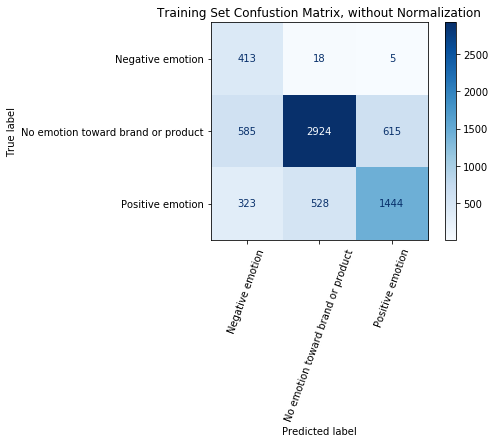

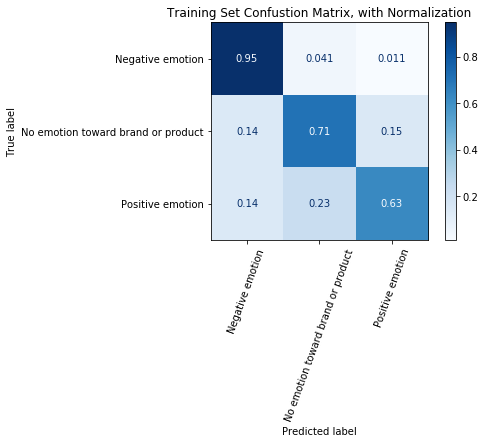

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.19      0.62      0.30       109
No emotion toward brand or product       0.78      0.61      0.68      1031
                  Positive emotion       0.54      0.53      0.54       574

                          accuracy                           0.58      1714
                         macro avg       0.51      0.59      0.51      1714
                      weighted avg       0.66      0.58      0.61      1714



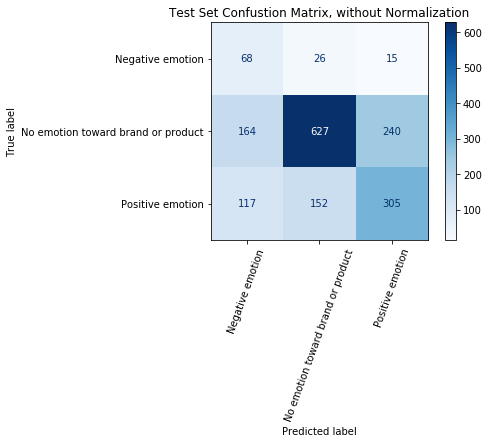

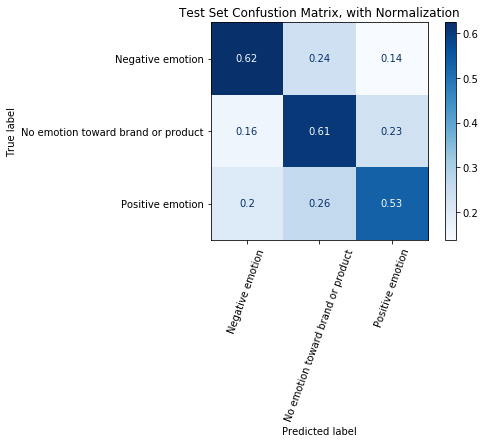

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 2

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.28      0.92      0.43       436
No emotion toward brand or product       0.84      0.69      0.76      4124
                  Positive emotion       0.69      0.60      0.64      2295

                          accuracy                           0.68      6855
                         macro avg       0.60      0.74      0.61      6855
                      weighted avg       0.75      0.68      0.70      6855



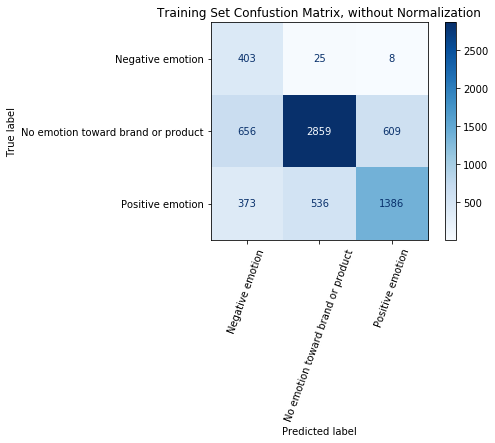

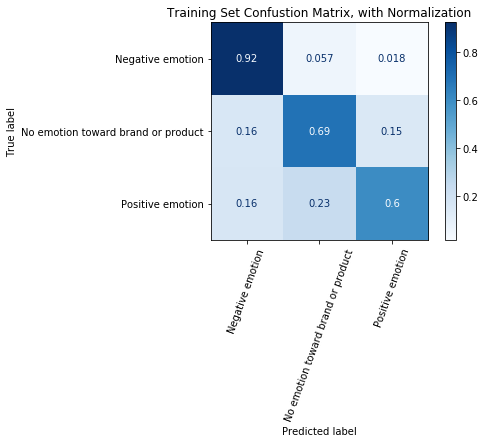

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.18      0.65      0.29       109
No emotion toward brand or product       0.79      0.61      0.69      1031
                  Positive emotion       0.56      0.51      0.53       574

                          accuracy                           0.58      1714
                         macro avg       0.51      0.59      0.50      1714
                      weighted avg       0.67      0.58      0.61      1714



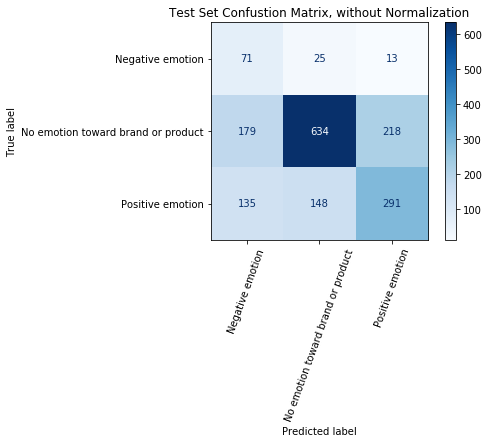

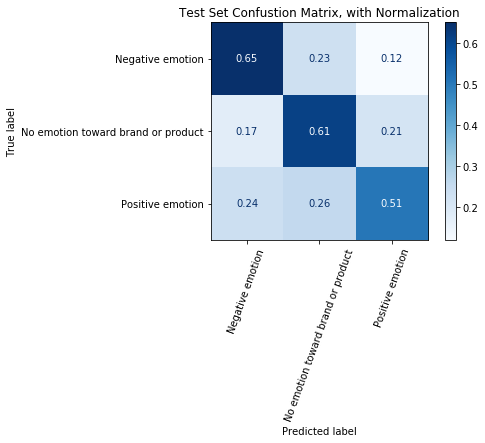

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 3

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.27      0.92      0.42       436
No emotion toward brand or product       0.83      0.69      0.75      4124
                  Positive emotion       0.69      0.60      0.64      2295

                          accuracy                           0.67      6855
                         macro avg       0.60      0.73      0.60      6855
                      weighted avg       0.75      0.67      0.69      6855



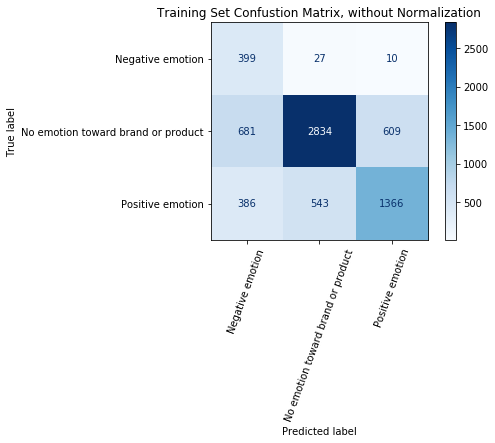

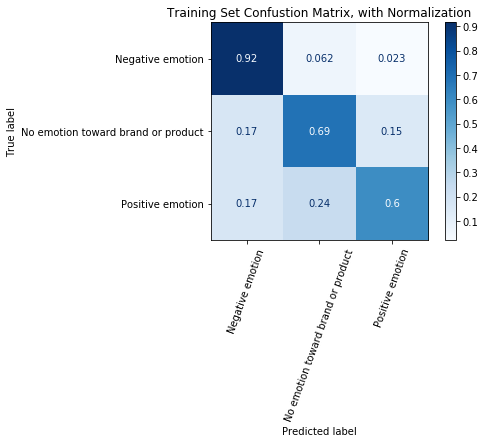

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.17      0.61      0.27       109
No emotion toward brand or product       0.77      0.61      0.68      1031
                  Positive emotion       0.54      0.49      0.52       574

                          accuracy                           0.57      1714
                         macro avg       0.50      0.57      0.49      1714
                      weighted avg       0.66      0.57      0.60      1714



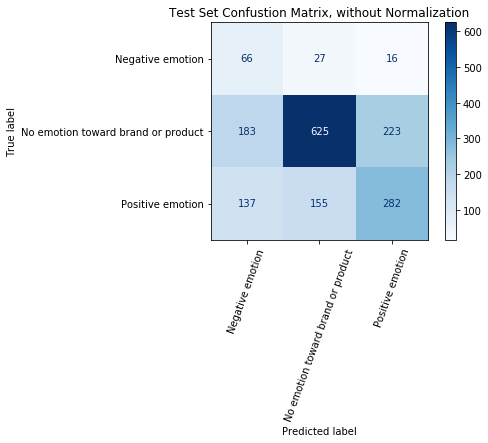

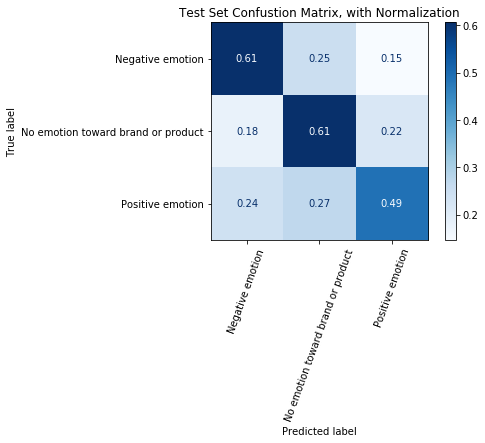

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 4

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.26      0.92      0.41       436
No emotion toward brand or product       0.83      0.67      0.74      4124
                  Positive emotion       0.68      0.58      0.63      2295

                          accuracy                           0.66      6855
                         macro avg       0.59      0.72      0.59      6855
                      weighted avg       0.74      0.66      0.68      6855



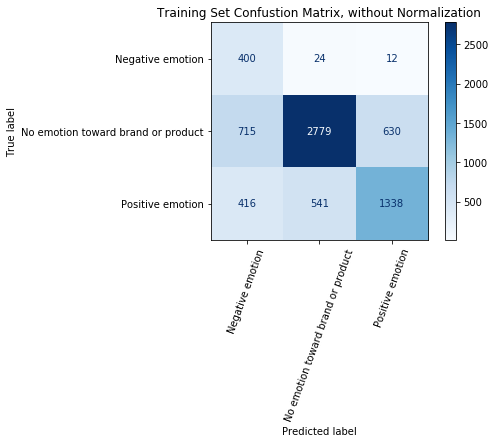

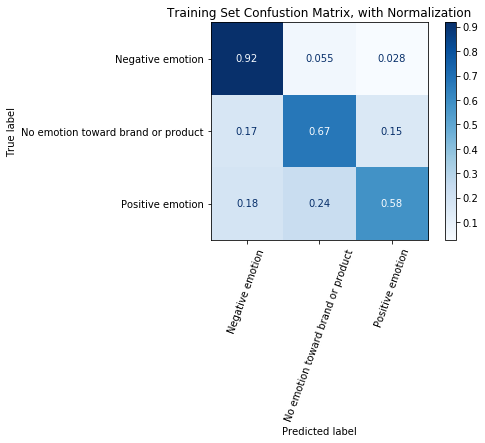

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.17      0.62      0.27       109
No emotion toward brand or product       0.78      0.59      0.67      1031
                  Positive emotion       0.54      0.50      0.52       574

                          accuracy                           0.56      1714
                         macro avg       0.50      0.57      0.49      1714
                      weighted avg       0.66      0.56      0.59      1714



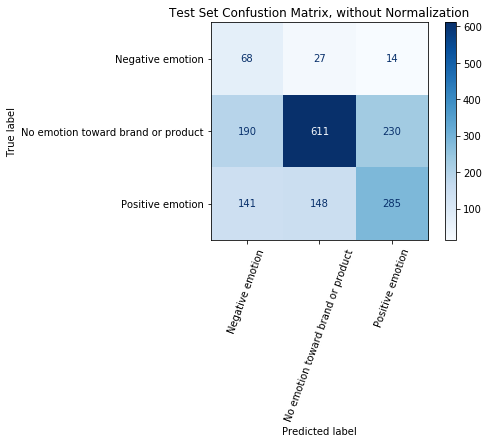

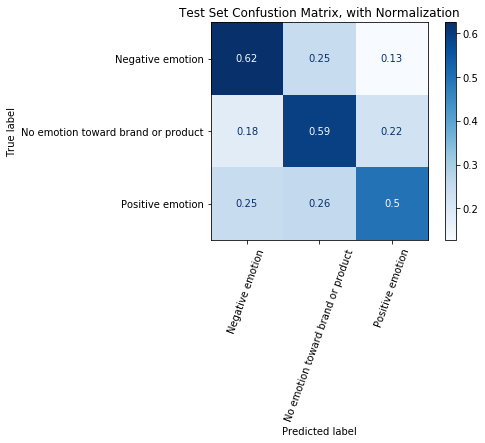

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 5

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.25      0.91      0.39       436
No emotion toward brand or product       0.83      0.67      0.74      4124
                  Positive emotion       0.67      0.57      0.62      2295

                          accuracy                           0.65      6855
                         macro avg       0.58      0.72      0.58      6855
                      weighted avg       0.74      0.65      0.68      6855



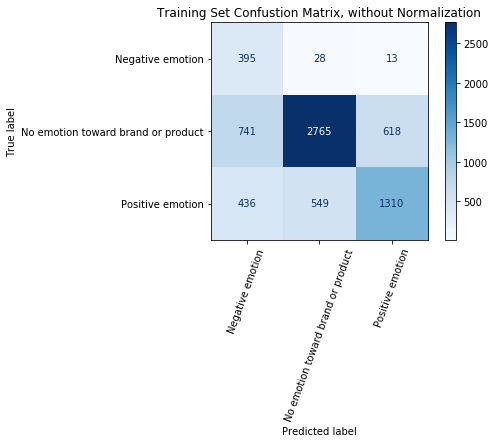

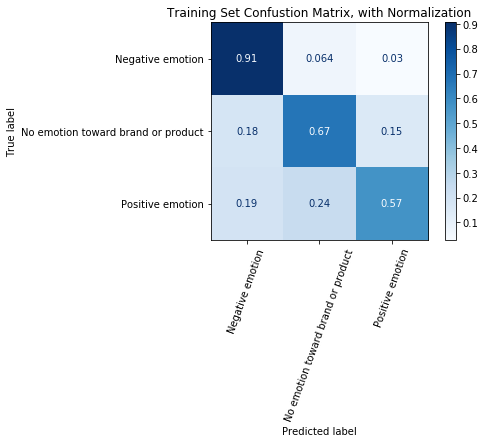

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.17      0.61      0.26       109
No emotion toward brand or product       0.77      0.60      0.67      1031
                  Positive emotion       0.53      0.48      0.50       574

                          accuracy                           0.56      1714
                         macro avg       0.49      0.56      0.48      1714
                      weighted avg       0.65      0.56      0.59      1714



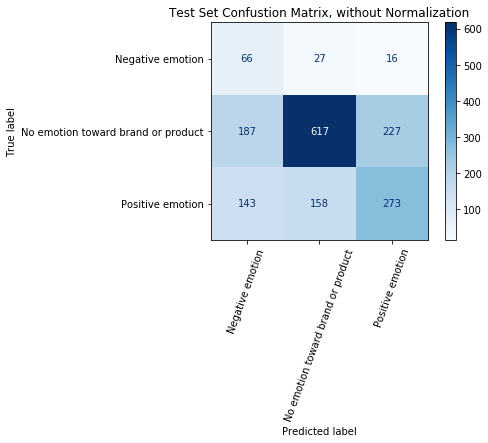

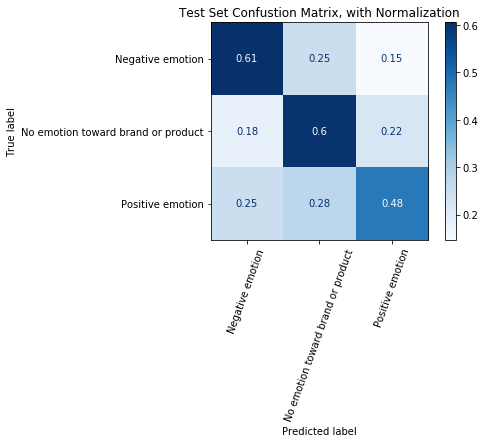

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 6

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.25      0.89      0.39       436
No emotion toward brand or product       0.83      0.67      0.74      4124
                  Positive emotion       0.67      0.57      0.61      2295

                          accuracy                           0.65      6855
                         macro avg       0.58      0.71      0.58      6855
                      weighted avg       0.74      0.65      0.67      6855



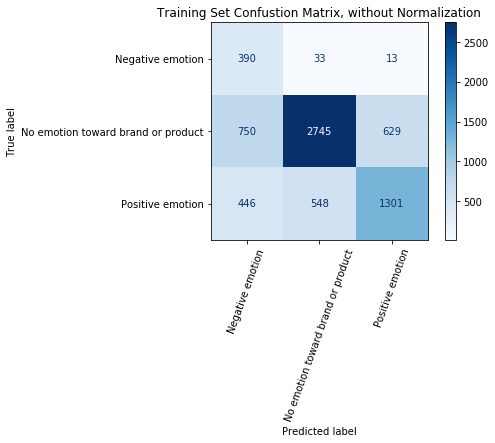

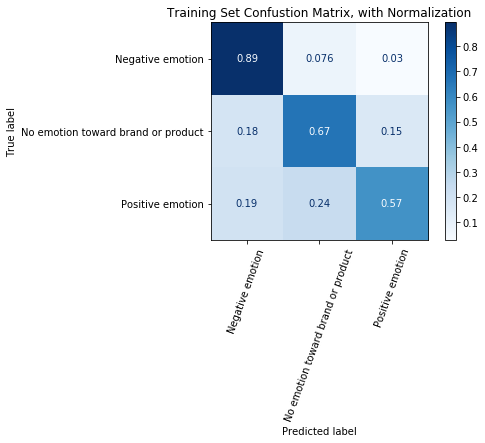

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.16      0.59      0.25       109
No emotion toward brand or product       0.77      0.59      0.67      1031
                  Positive emotion       0.53      0.48      0.50       574

                          accuracy                           0.55      1714
                         macro avg       0.49      0.55      0.48      1714
                      weighted avg       0.65      0.55      0.59      1714



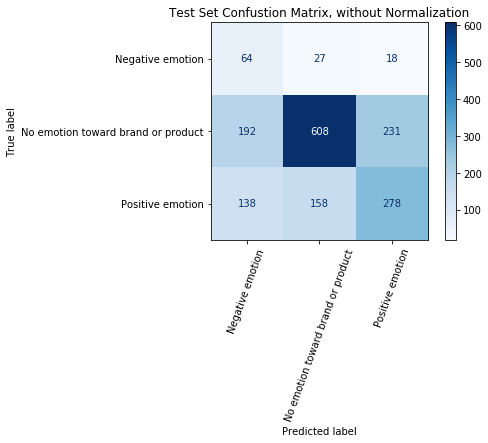

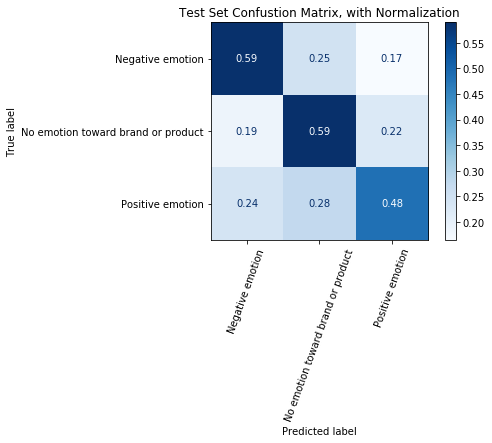

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 7

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.24      0.89      0.38       436
No emotion toward brand or product       0.82      0.66      0.73      4124
                  Positive emotion       0.67      0.57      0.61      2295

                          accuracy                           0.64      6855
                         macro avg       0.58      0.71      0.58      6855
                      weighted avg       0.73      0.64      0.67      6855



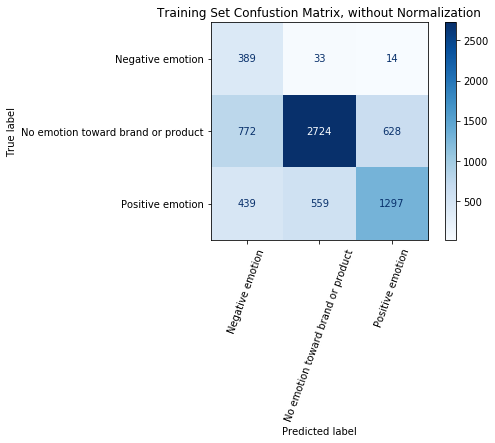

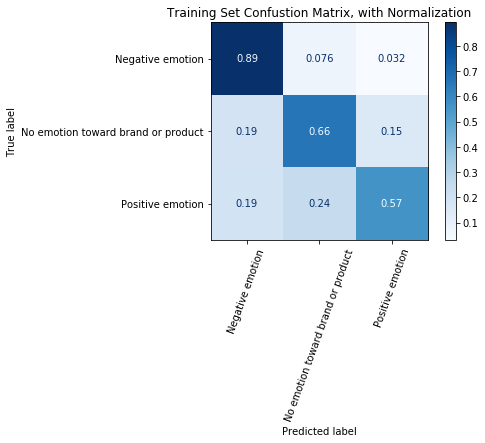

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.17      0.63      0.26       109
No emotion toward brand or product       0.77      0.58      0.66      1031
                  Positive emotion       0.53      0.48      0.51       574

                          accuracy                           0.55      1714
                         macro avg       0.49      0.57      0.48      1714
                      weighted avg       0.65      0.55      0.59      1714



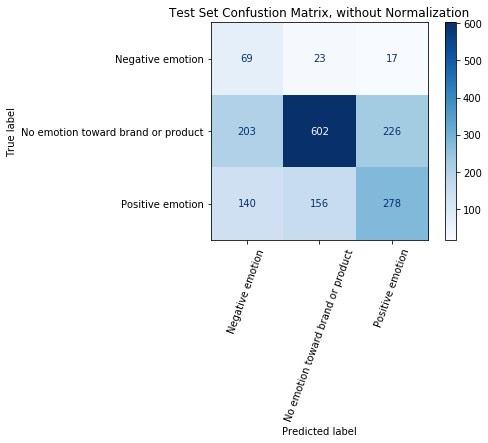

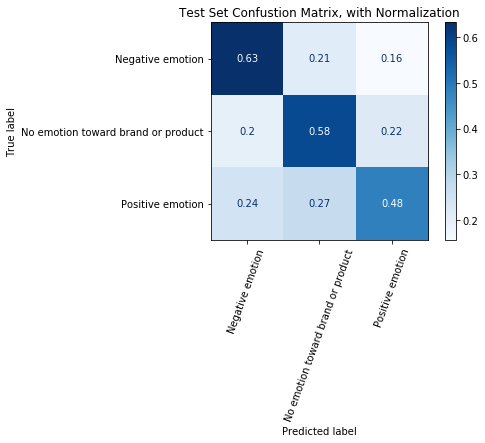

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 8

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.24      0.90      0.38       436
No emotion toward brand or product       0.82      0.65      0.72      4124
                  Positive emotion       0.66      0.56      0.61      2295

                          accuracy                           0.64      6855
                         macro avg       0.57      0.70      0.57      6855
                      weighted avg       0.73      0.64      0.66      6855



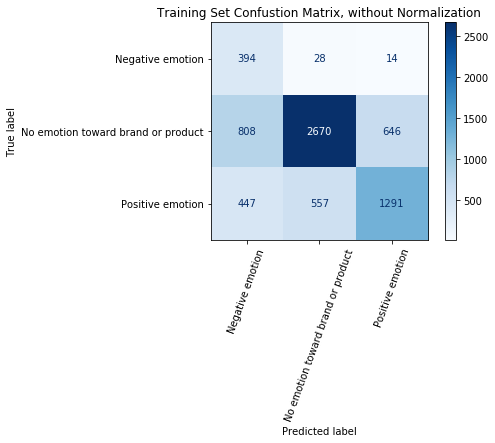

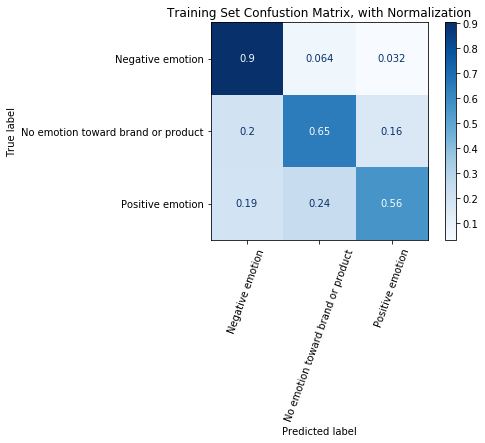

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.16      0.62      0.26       109
No emotion toward brand or product       0.78      0.58      0.66      1031
                  Positive emotion       0.54      0.49      0.51       574

                          accuracy                           0.55      1714
                         macro avg       0.49      0.56      0.48      1714
                      weighted avg       0.66      0.55      0.59      1714



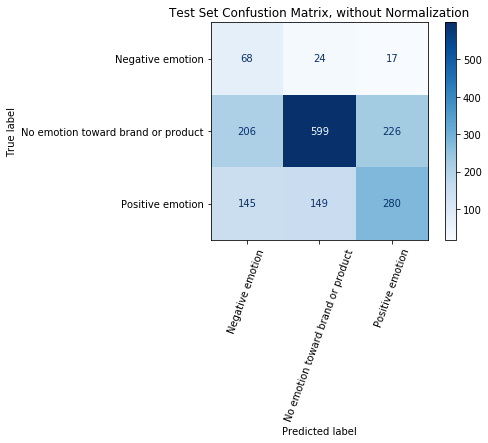

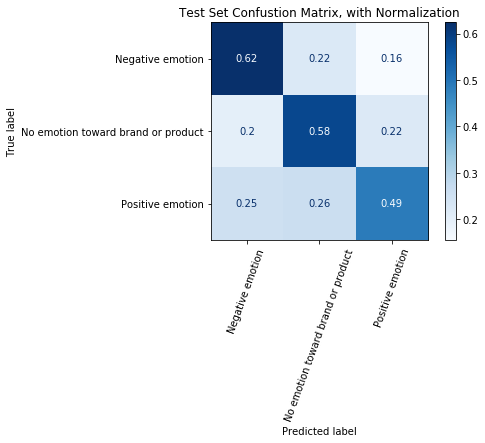

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 9

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.24      0.90      0.38       436
No emotion toward brand or product       0.82      0.64      0.72      4124
                  Positive emotion       0.66      0.56      0.61      2295

                          accuracy                           0.63      6855
                         macro avg       0.57      0.70      0.57      6855
                      weighted avg       0.73      0.63      0.66      6855



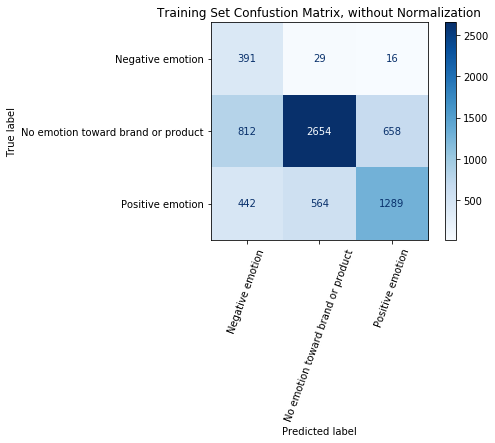

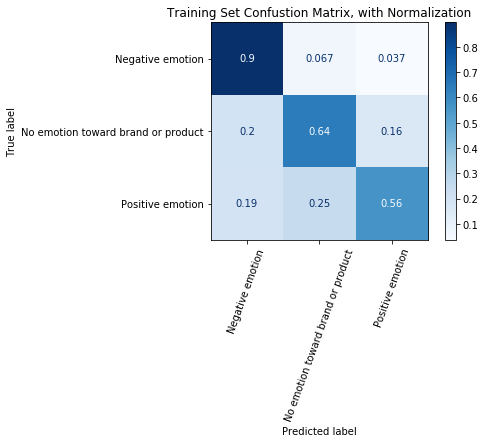

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.17      0.63      0.26       109
No emotion toward brand or product       0.78      0.58      0.67      1031
                  Positive emotion       0.54      0.50      0.52       574

                          accuracy                           0.56      1714
                         macro avg       0.50      0.57      0.48      1714
                      weighted avg       0.66      0.56      0.59      1714



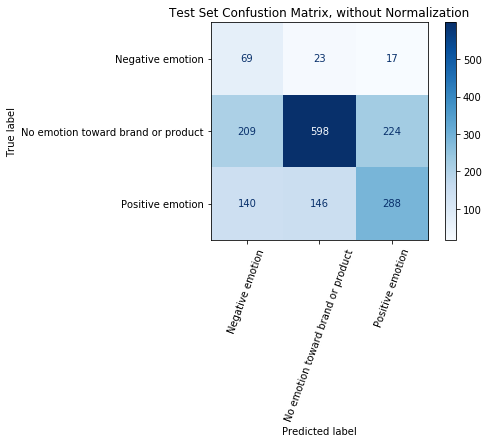

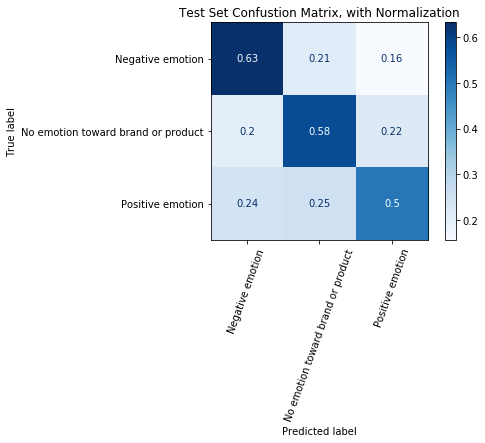

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 10

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.23      0.89      0.37       436
No emotion toward brand or product       0.81      0.65      0.72      4124
                  Positive emotion       0.66      0.54      0.59      2295

                          accuracy                           0.63      6855
                         macro avg       0.57      0.69      0.56      6855
                      weighted avg       0.72      0.63      0.66      6855



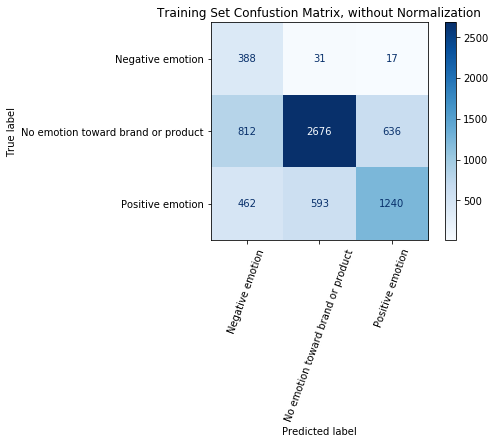

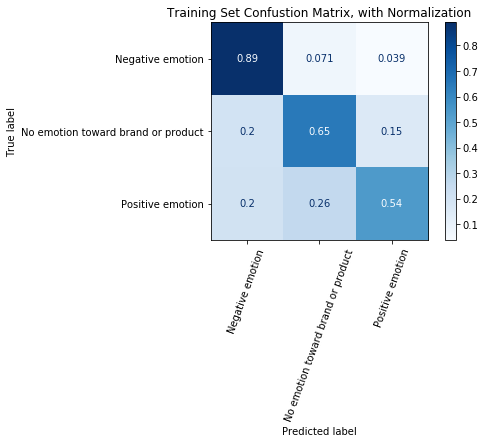

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.16      0.63      0.26       109
No emotion toward brand or product       0.78      0.58      0.67      1031
                  Positive emotion       0.53      0.48      0.51       574

                          accuracy                           0.55      1714
                         macro avg       0.49      0.57      0.48      1714
                      weighted avg       0.66      0.55      0.59      1714



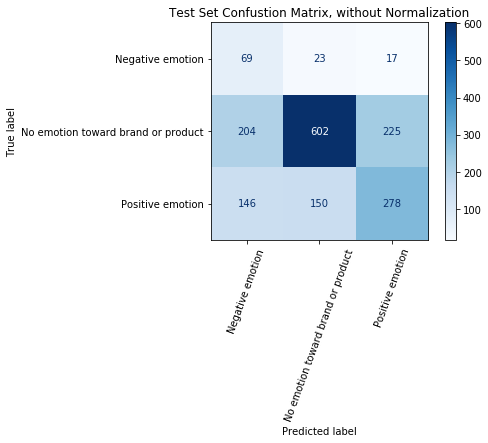

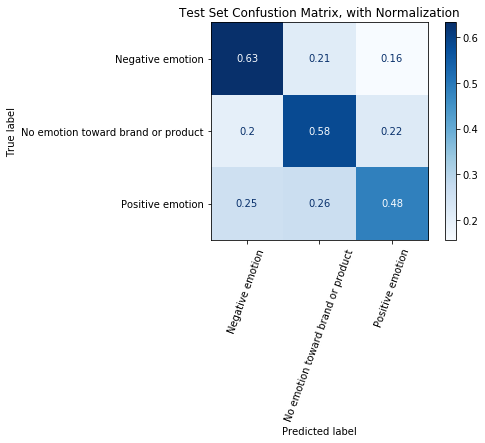

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 11

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.23      0.89      0.37       436
No emotion toward brand or product       0.81      0.65      0.72      4124
                  Positive emotion       0.65      0.54      0.59      2295

                          accuracy                           0.63      6855
                         macro avg       0.57      0.69      0.56      6855
                      weighted avg       0.72      0.63      0.66      6855



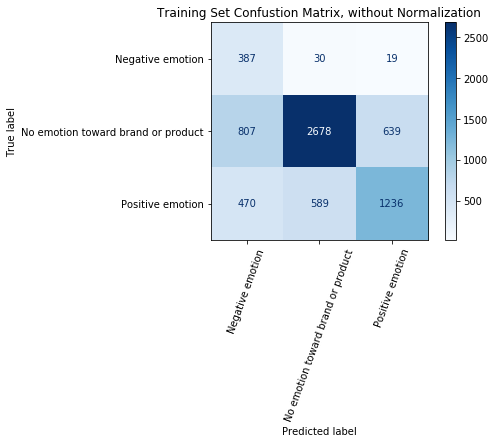

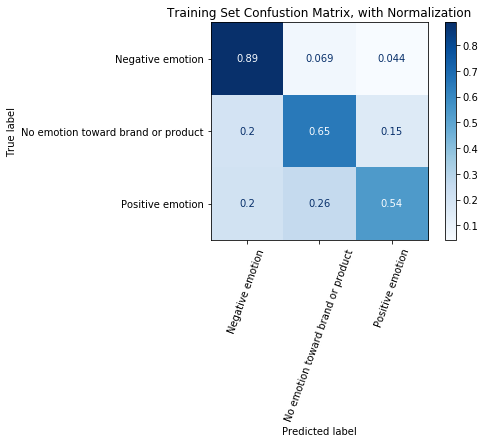

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.16      0.61      0.25       109
No emotion toward brand or product       0.77      0.58      0.66      1031
                  Positive emotion       0.53      0.47      0.50       574

                          accuracy                           0.55      1714
                         macro avg       0.49      0.56      0.47      1714
                      weighted avg       0.65      0.55      0.58      1714



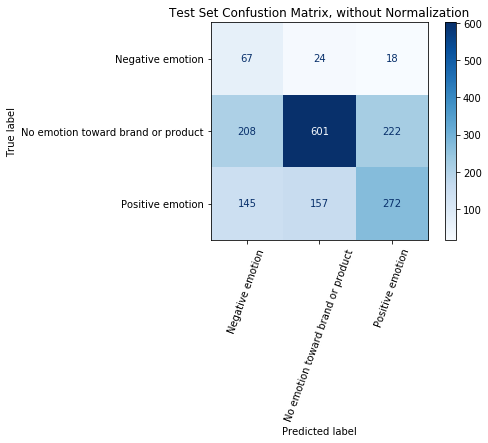

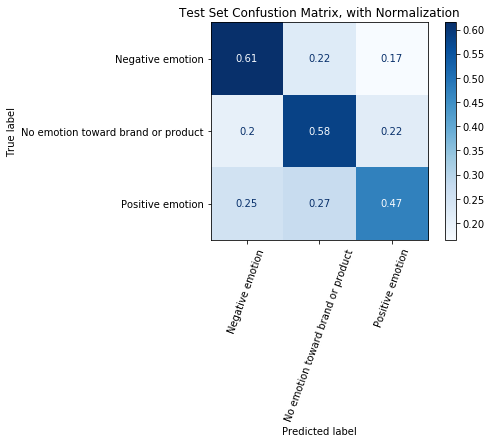

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 12

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.23      0.88      0.37       436
No emotion toward brand or product       0.81      0.65      0.72      4124
                  Positive emotion       0.65      0.53      0.58      2295

                          accuracy                           0.62      6855
                         macro avg       0.56      0.69      0.56      6855
                      weighted avg       0.72      0.62      0.65      6855



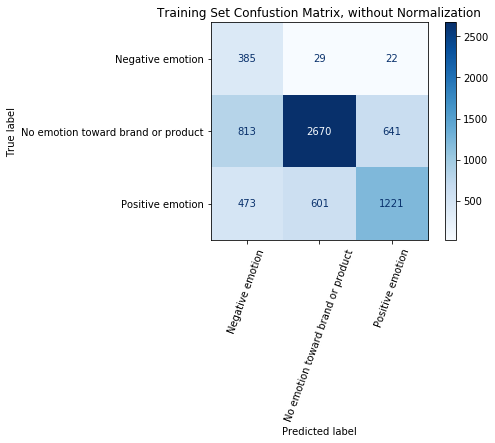

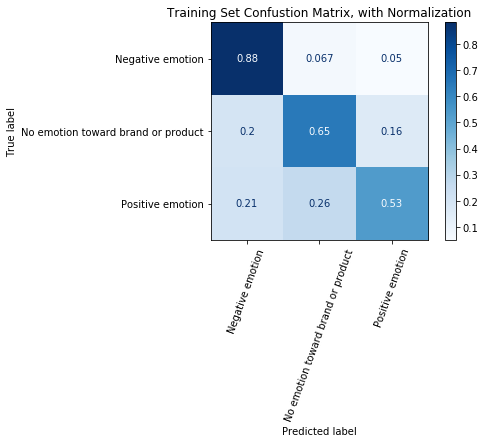

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.15      0.60      0.24       109
No emotion toward brand or product       0.77      0.58      0.66      1031
                  Positive emotion       0.53      0.47      0.50       574

                          accuracy                           0.54      1714
                         macro avg       0.48      0.55      0.47      1714
                      weighted avg       0.65      0.54      0.58      1714



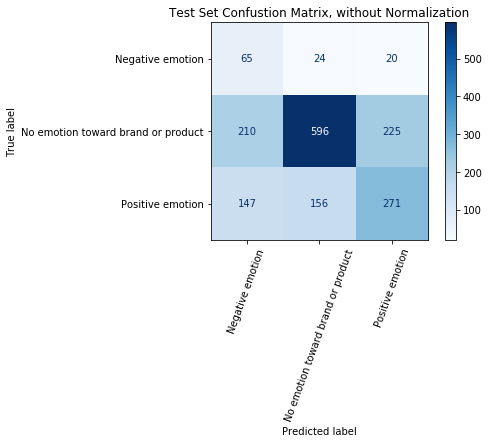

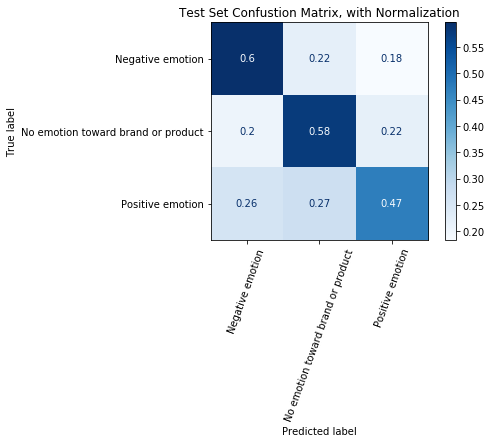

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 13

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.23      0.88      0.36       436
No emotion toward brand or product       0.81      0.64      0.72      4124
                  Positive emotion       0.65      0.54      0.59      2295

                          accuracy                           0.62      6855
                         macro avg       0.56      0.69      0.55      6855
                      weighted avg       0.72      0.62      0.65      6855



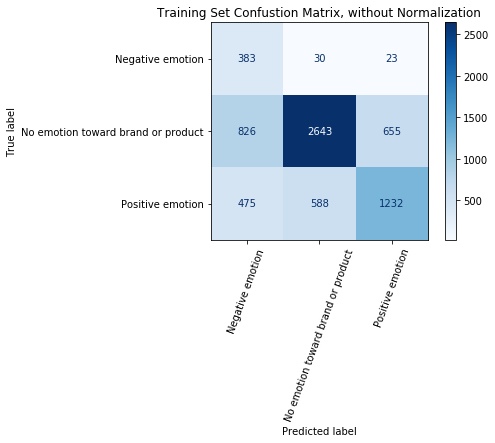

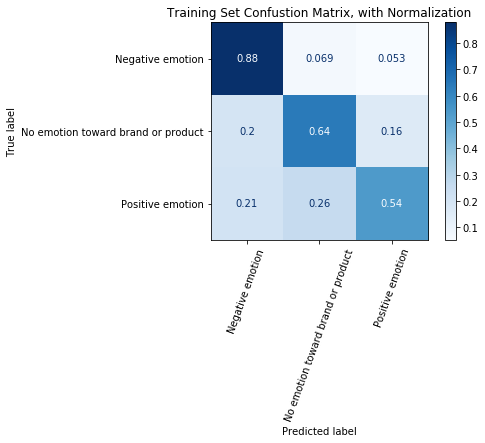

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.16      0.61      0.25       109
No emotion toward brand or product       0.76      0.57      0.65      1031
                  Positive emotion       0.51      0.46      0.48       574

                          accuracy                           0.54      1714
                         macro avg       0.48      0.55      0.46      1714
                      weighted avg       0.64      0.54      0.57      1714



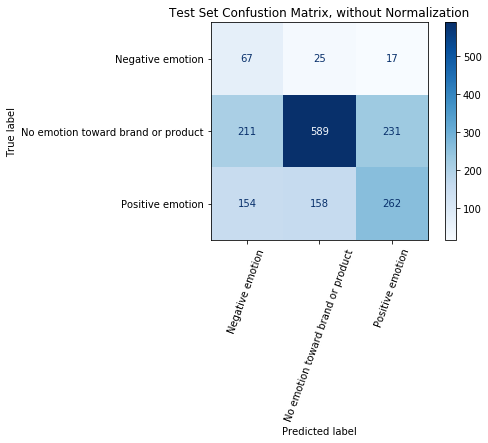

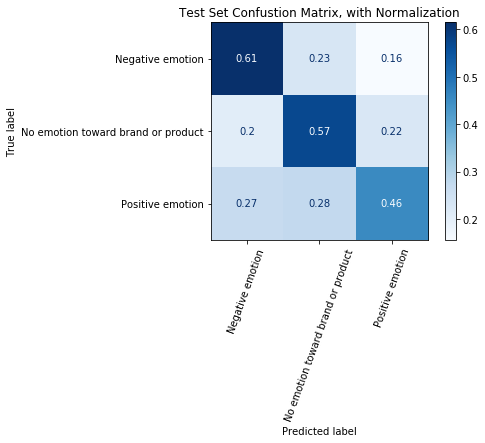

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 14

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.23      0.88      0.36       436
No emotion toward brand or product       0.81      0.64      0.72      4124
                  Positive emotion       0.64      0.53      0.58      2295

                          accuracy                           0.62      6855
                         macro avg       0.56      0.69      0.55      6855
                      weighted avg       0.72      0.62      0.65      6855



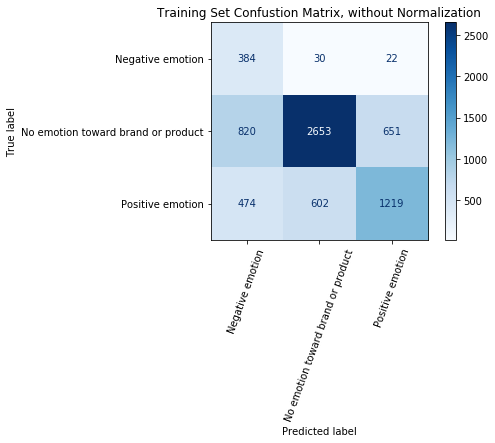

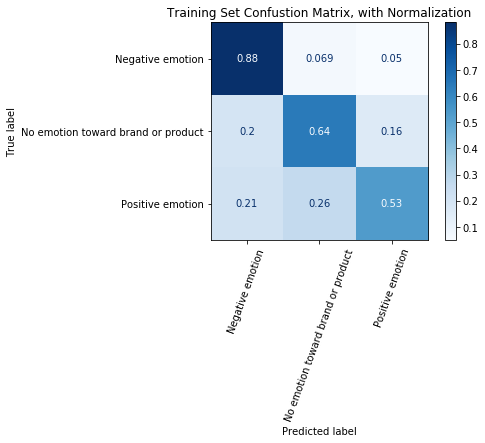

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.15      0.60      0.24       109
No emotion toward brand or product       0.76      0.58      0.66      1031
                  Positive emotion       0.52      0.46      0.49       574

                          accuracy                           0.54      1714
                         macro avg       0.48      0.54      0.46      1714
                      weighted avg       0.64      0.54      0.57      1714



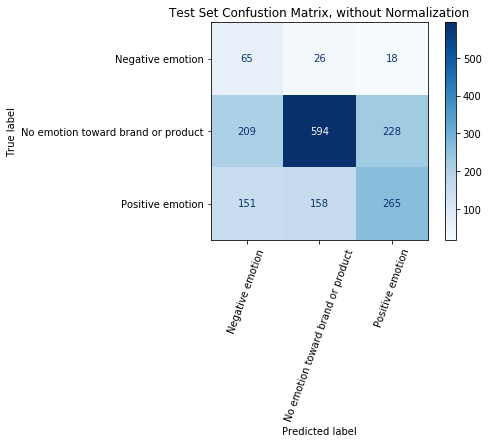

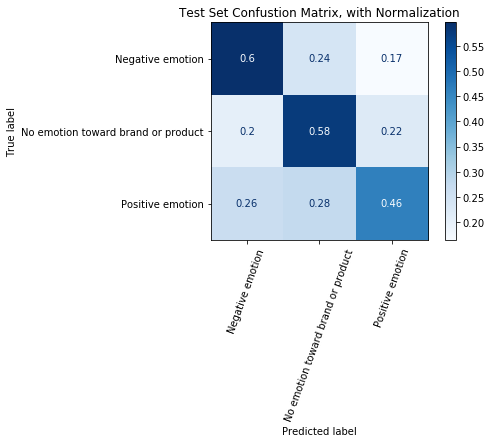

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 15

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.22      0.88      0.36       436
No emotion toward brand or product       0.81      0.64      0.71      4124
                  Positive emotion       0.64      0.53      0.58      2295

                          accuracy                           0.62      6855
                         macro avg       0.56      0.68      0.55      6855
                      weighted avg       0.72      0.62      0.65      6855



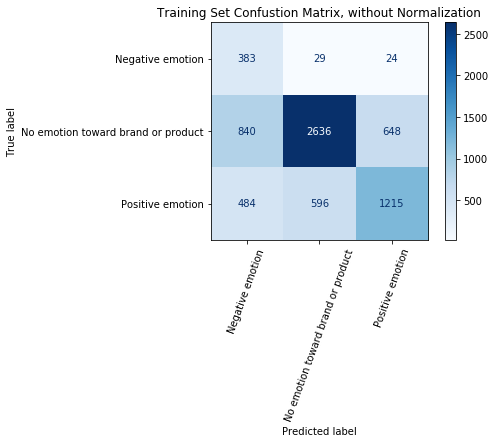

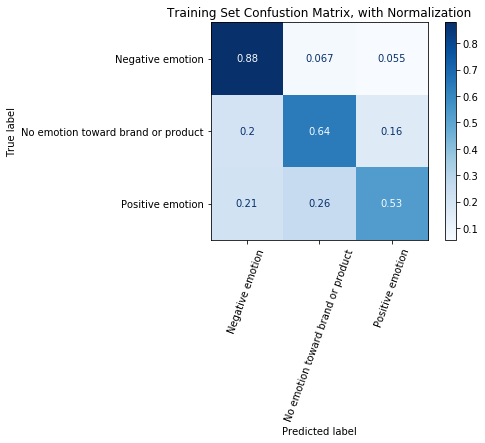

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.15      0.59      0.24       109
No emotion toward brand or product       0.76      0.58      0.66      1031
                  Positive emotion       0.52      0.46      0.49       574

                          accuracy                           0.54      1714
                         macro avg       0.48      0.54      0.46      1714
                      weighted avg       0.64      0.54      0.58      1714



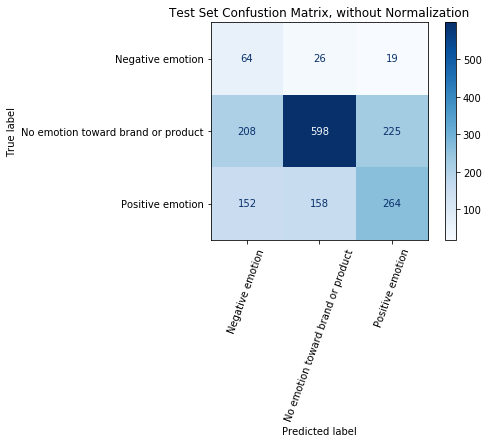

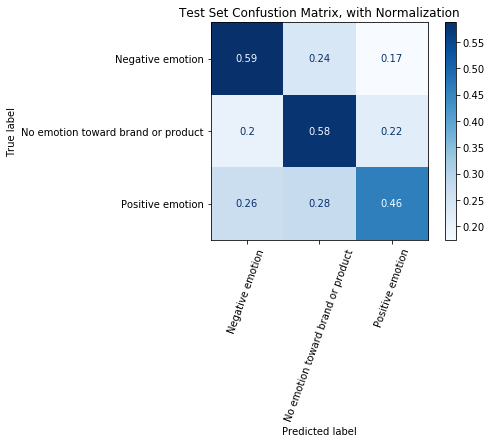

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 16

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.22      0.87      0.35       436
No emotion toward brand or product       0.81      0.63      0.71      4124
                  Positive emotion       0.64      0.53      0.58      2295

                          accuracy                           0.61      6855
                         macro avg       0.56      0.68      0.55      6855
                      weighted avg       0.71      0.61      0.64      6855



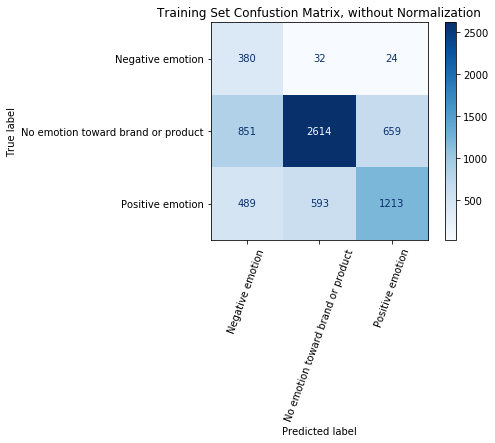

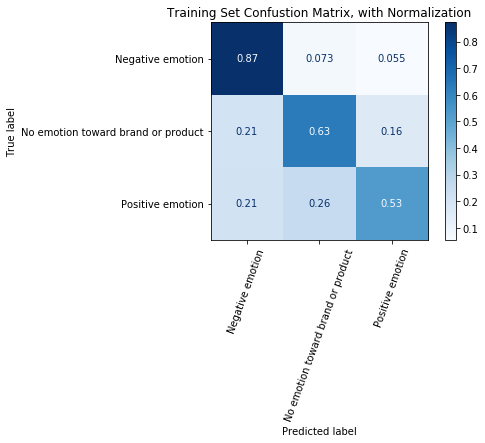

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.15      0.60      0.24       109
No emotion toward brand or product       0.77      0.58      0.66      1031
                  Positive emotion       0.52      0.46      0.49       574

                          accuracy                           0.54      1714
                         macro avg       0.48      0.54      0.46      1714
                      weighted avg       0.64      0.54      0.57      1714



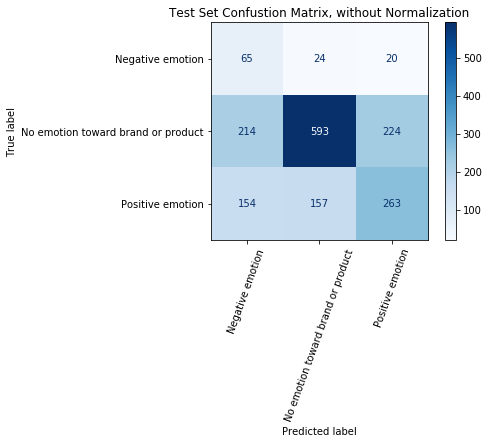

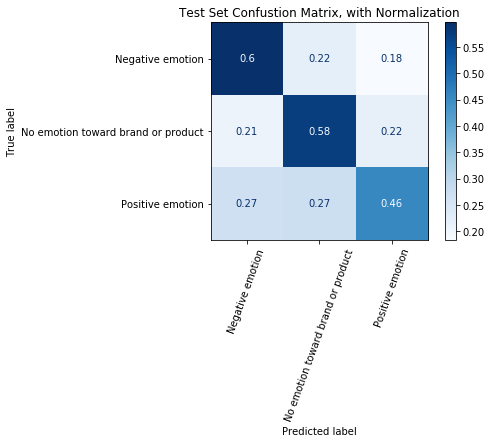

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 17

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.22      0.88      0.35       436
No emotion toward brand or product       0.81      0.63      0.71      4124
                  Positive emotion       0.65      0.53      0.58      2295

                          accuracy                           0.61      6855
                         macro avg       0.56      0.68      0.55      6855
                      weighted avg       0.72      0.61      0.64      6855



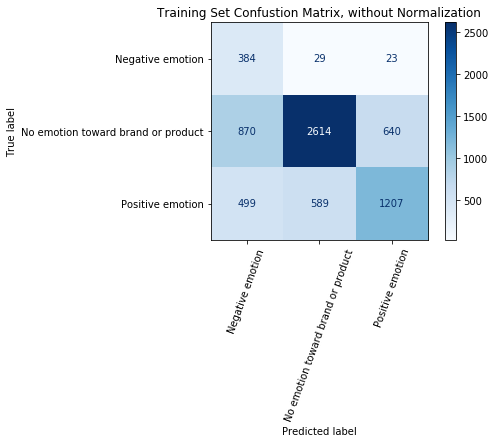

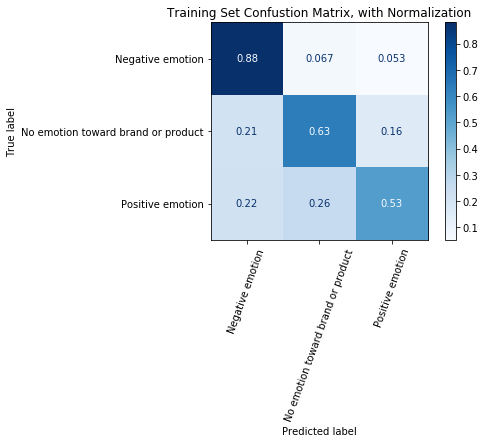

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.14      0.59      0.23       109
No emotion toward brand or product       0.77      0.57      0.65      1031
                  Positive emotion       0.51      0.45      0.48       574

                          accuracy                           0.53      1714
                         macro avg       0.47      0.54      0.45      1714
                      weighted avg       0.64      0.53      0.57      1714



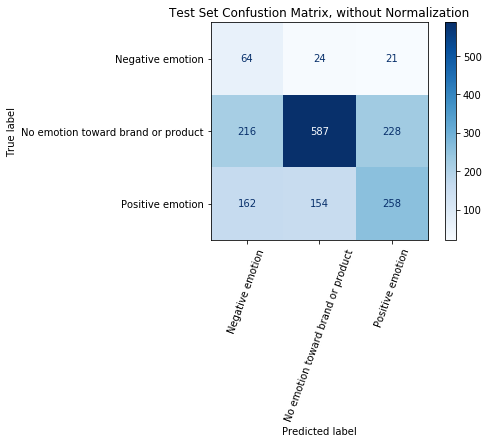

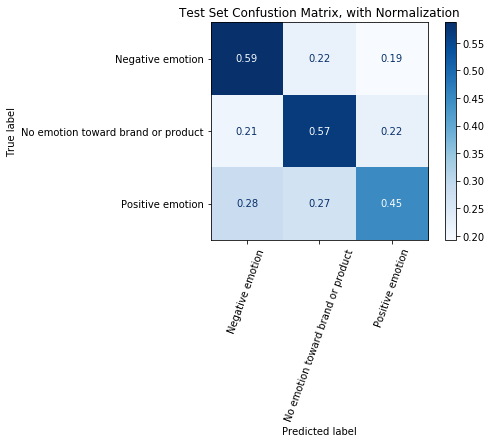

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 18

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.22      0.88      0.35       436
No emotion toward brand or product       0.80      0.64      0.71      4124
                  Positive emotion       0.64      0.51      0.57      2295

                          accuracy                           0.61      6855
                         macro avg       0.56      0.68      0.55      6855
                      weighted avg       0.71      0.61      0.64      6855



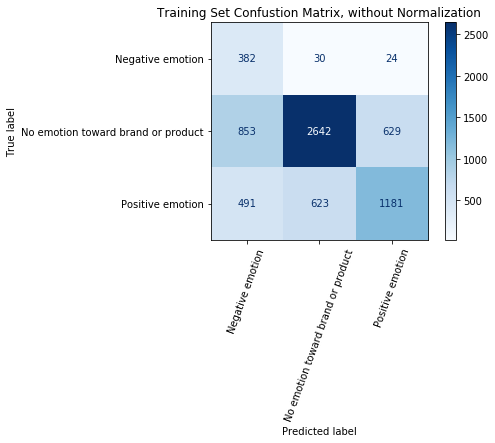

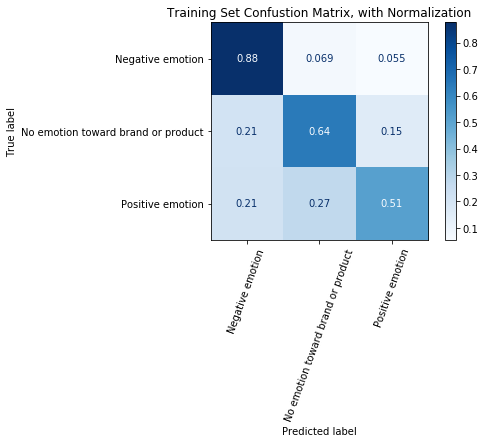

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.15      0.60      0.24       109
No emotion toward brand or product       0.77      0.58      0.66      1031
                  Positive emotion       0.51      0.45      0.48       574

                          accuracy                           0.54      1714
                         macro avg       0.48      0.54      0.46      1714
                      weighted avg       0.64      0.54      0.57      1714



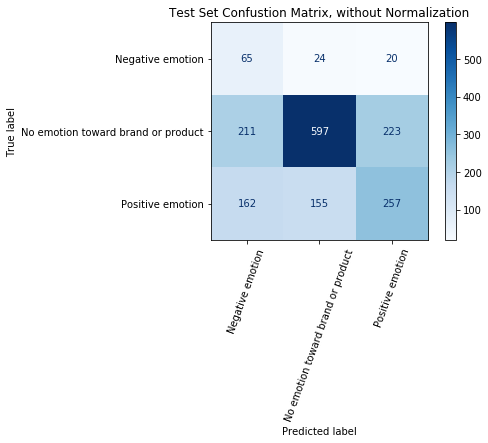

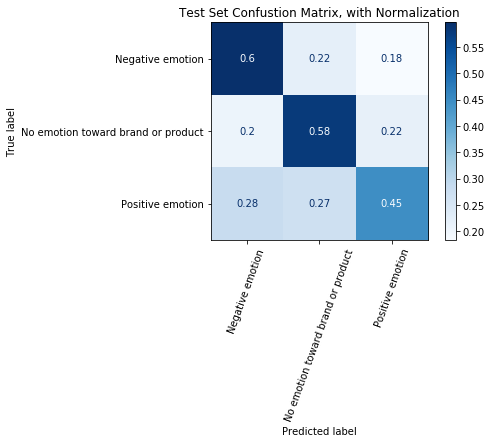

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 19

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.22      0.87      0.35       436
No emotion toward brand or product       0.80      0.64      0.71      4124
                  Positive emotion       0.64      0.51      0.57      2295

                          accuracy                           0.61      6855
                         macro avg       0.55      0.67      0.54      6855
                      weighted avg       0.71      0.61      0.64      6855



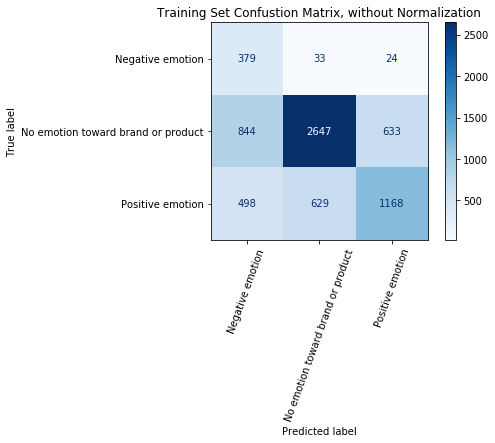

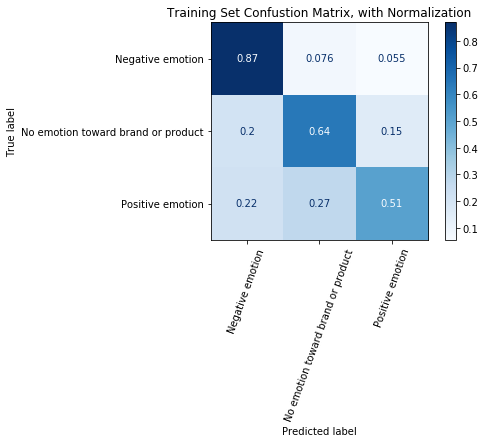

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.15      0.60      0.24       109
No emotion toward brand or product       0.77      0.58      0.66      1031
                  Positive emotion       0.51      0.45      0.48       574

                          accuracy                           0.54      1714
                         macro avg       0.48      0.54      0.46      1714
                      weighted avg       0.64      0.54      0.57      1714



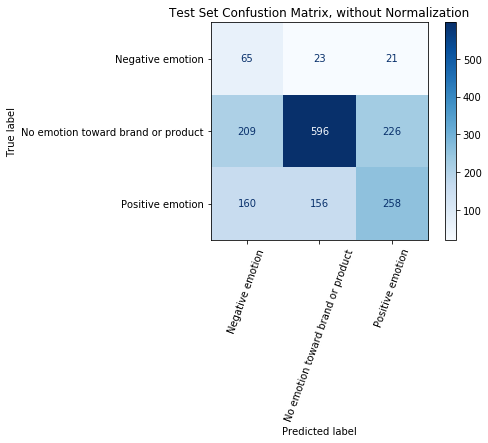

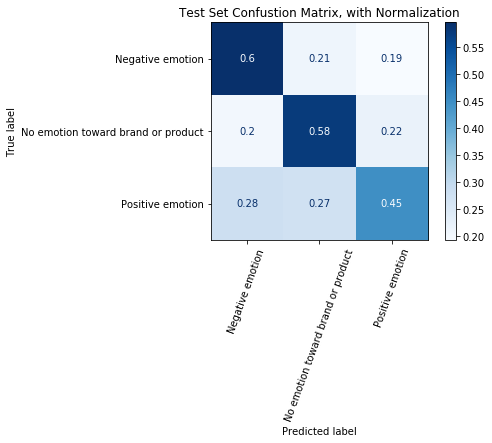

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 20

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.22      0.87      0.35       436
No emotion toward brand or product       0.80      0.64      0.71      4124
                  Positive emotion       0.64      0.51      0.56      2295

                          accuracy                           0.61      6855
                         macro avg       0.55      0.67      0.54      6855
                      weighted avg       0.71      0.61      0.64      6855



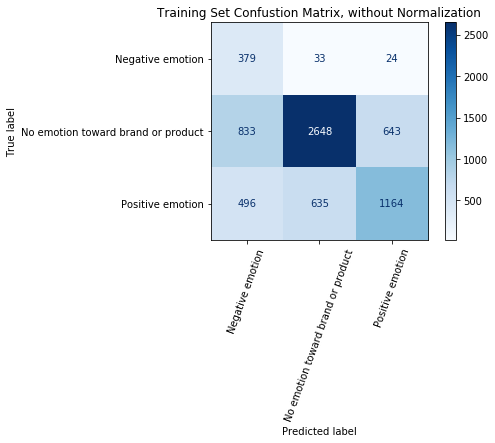

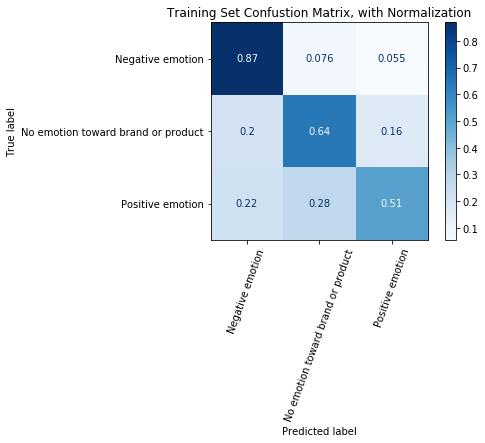

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.15      0.59      0.24       109
No emotion toward brand or product       0.77      0.58      0.66      1031
                  Positive emotion       0.51      0.45      0.48       574

                          accuracy                           0.54      1714
                         macro avg       0.48      0.54      0.46      1714
                      weighted avg       0.64      0.54      0.57      1714



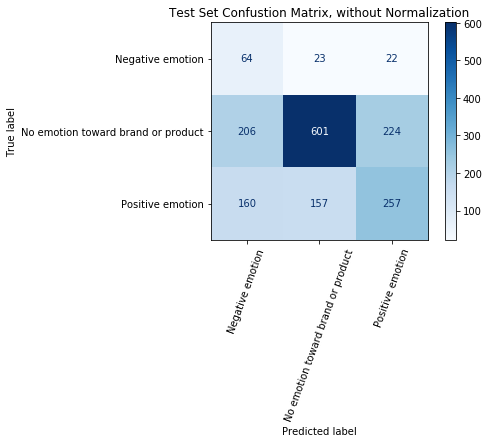

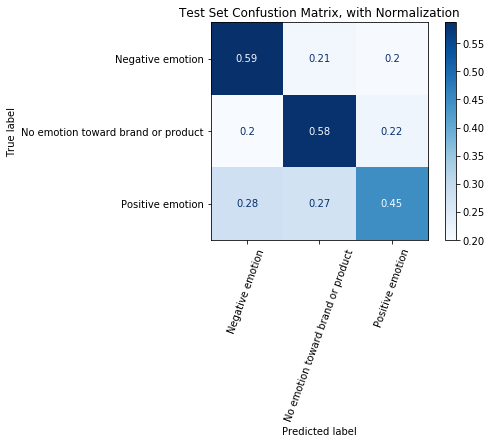

In [14]:
metrics_summary = []

for min_df in range(1,21):
    test_scores = train_and_eval_model(min_df)
    metrics_summary.append(test_scores)

In [15]:
metrics_summary_df = pd.DataFrame(metrics_summary, 
                                  columns=['min doc freq',
                                           'train accuracy',
                                           'test accuracy',
                                          'neg f1',
                                          'neutral f1',
                                          'pos f1'])

metrics_summary_df

,min doc freq,train accuracy,test accuracy,neg f1,neutral f1,pos f1
0,1.0,0.697447,0.583431,0.296943,0.683007,0.537919
1,2.0,0.678045,0.581097,0.287449,0.689880,0.531022
2,3.0,0.670897,0.567678,0.266667,0.680087,0.515068
3,4.0,0.658935,0.562427,0.267717,0.672537,0.516772
4,5.0,0.652079,0.557760,0.261386,0.673213,0.500917
5,6.0,0.647119,0.554259,0.254473,0.666667,0.504995
6,7.0,0.643326,0.553676,0.264875,0.664459,0.507763
7,8.0,0.635303,0.552509,0.257576,0.664448,0.510483
8,9.0,0.632239,0.557176,0.261860,0.665184,0.522212
9,10.0,0.627863,0.553676,0.261364,0.666667,0.508227


/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 5

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.25      0.91      0.39       436
No emotion toward brand or product       0.83      0.67      0.74      4124
                  Positive emotion       0.67      0.57      0.62      2295

                          accuracy                           0.65      6855
                         macro avg       0.58      0.72      0.58      6855
                      weighted avg       0.74      0.65      0.68      6855



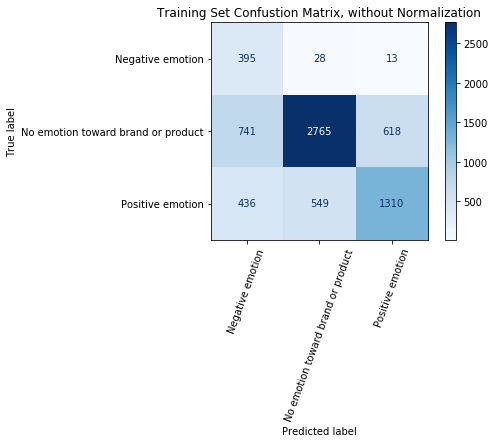

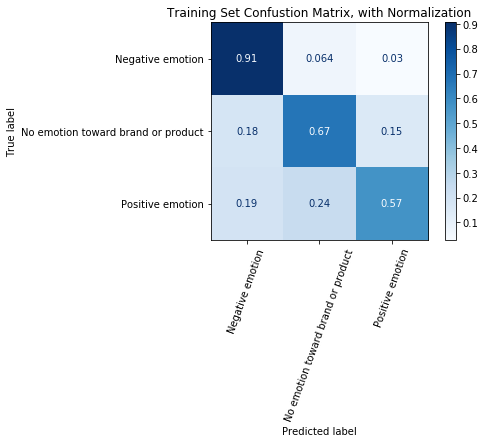

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.17      0.61      0.26       109
No emotion toward brand or product       0.77      0.60      0.67      1031
                  Positive emotion       0.53      0.48      0.50       574

                          accuracy                           0.56      1714
                         macro avg       0.49      0.56      0.48      1714
                      weighted avg       0.65      0.56      0.59      1714



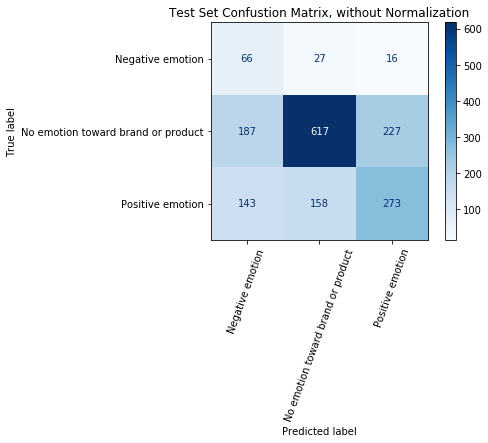

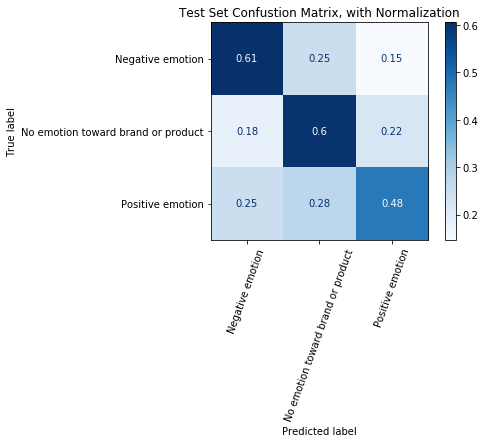

In [16]:
metrics = train_and_eval_model(min_df=5)

# Summary

When adjusting the minimum document frequency for words, the best performing setting was 5, when using the F1 scores and accuracy as metrics.

However this model is only good, and it is very good, at correctly classifying actual members of the majority class as from that class.